In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from dmrgwaytorho import *
import qutip as q
from scipy import integrate,special
from scipy.linalg import eig,eigh,eigvals,eigvalsh
from scipy.sparse.linalg import eigs
import pickle 
from functions import doApplyHam,isingmodel,diagonalize
from functions import isingmodel_rev,isingmodel_rev_frac2


In [2]:
L=2
length=16
lambdarange=np.linspace(0.1,2)


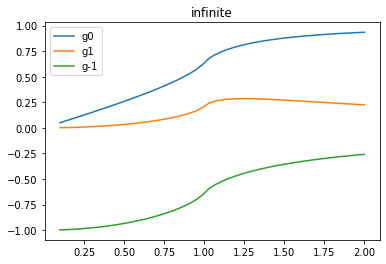

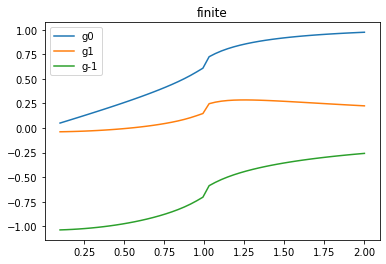

In [10]:
N=50
    
def gzerok(N,lamb):
    g=0.0
    for k in np.arange(N/2+1):
        g+=(lamb-np.cos(2*np.pi*k/N))/np.sqrt(1+lamb**2-2*lamb*np.cos(2*np.pi*k/N))
    return 2*g/N
def gunok(N,lamb):
    g=0.0
    for k in np.arange(N/2+1):
        g+=(lamb*np.cos(2*np.pi*k/N)-np.cos(2*2*np.pi*k/N))/np.sqrt(1+lamb**2-2*lamb*np.cos(2*np.pi*k/N))
    return 2*g/N
def gmenounok(N,lamb):
    g=0.0
    for k in np.arange(N/2+1):
        g+=(lamb*np.cos(2*np.pi*k/N)-1)/np.sqrt(1+lamb**2-2*lamb*np.cos(2*np.pi*k/N))
    return 2*g/N 

def gzero(phi,lamb):
    return (1/(2*np.pi))*(lamb-np.cos(phi))/np.sqrt(1+lamb**2-2*lamb*np.cos(phi))
def guno(phi,lamb):
    return (1/(2*np.pi))*(lamb*np.cos(phi)-np.cos(2*phi))/np.sqrt(1+lamb**2-2*lamb*np.cos(phi))  
def gmenouno(phi,lamb):
    return (1/(2*np.pi))*(lamb*np.cos(phi)-1)/np.sqrt(1+lamb**2-2*lamb*np.cos(phi))
i0vec=np.zeros_like(lambdarange)
i1vec=np.zeros_like(lambdarange)
im1vec=np.zeros_like(lambdarange)

for i,lam in enumerate(lambdarange):
    I_0=integrate.quad(gzero,0,2*np.pi,args=(lam))
    I_1=integrate.quad(guno,0,2*np.pi,args=(lam))
    I_m1=integrate.quad(gmenouno,0,2*np.pi,args=(lam))
    i0vec[i]=I_0[0]
    i1vec[i]=I_1[0]
    im1vec[i]=I_m1[0]
    
plt.plot(lambdarange,i0vec,label="g0")
plt.plot(lambdarange,i1vec,label="g1")
plt.plot(lambdarange,im1vec,label="g-1")
plt.legend()
plt.title("infinite")
plt.show() 

for i,lam in enumerate(lambdarange):
    i0vec[i]=gzerok(N,lam)
    i1vec[i]=gunok(N,lam)
    im1vec[i]=gmenounok(N,lam)
    
plt.plot(lambdarange,i0vec,label="g0")
plt.plot(lambdarange,i1vec,label="g1")
plt.plot(lambdarange,im1vec,label="g-1")
plt.legend()
plt.title("finite")
plt.show()    

  
def rho_2_finite(x):
    return (1/4)*(q.tensor(q.qeye(2),q.qeye(2))-im1vec[x]*q.tensor(q.sigmax(),q.sigmax())-i1vec[x]*q.tensor(q.sigmay(),q.sigmay())+ \
                  (i0vec[x]**2-i1vec[x]*im1vec[x])*q.tensor(q.sigmaz(),q.sigmaz())+i0vec[x]*(q.tensor(q.qeye(2),q.sigmaz())+q.tensor(q.sigmaz(),q.qeye(2))))

In [4]:
dictionary_open0={}
dictionary_open1={}

for l in lambdarange:
    
    Energies,psis=diagonalize(2,length,isingmodel_rev_frac2(l,0.0001),False)
    
    reshapedpsi0=psis[:,0].reshape(2**int((length-2)/2),4,2**int((length-2)/2)).transpose(1,0,2).reshape(4,-1)
    
    rhomagn0 = np.dot(reshapedpsi0, reshapedpsi0.conjugate().transpose())
    
    reshapedpsi1=psis[:,1].reshape(2**int((length-2)/2),4,2**int((length-2)/2)).transpose(1,0,2).reshape(4,-1)
    
    rhomagn1 = np.dot(reshapedpsi1, reshapedpsi1.conjugate().transpose())
    
    dictionary_open0[l]=rhomagn0
    
    dictionary_open1[l]=rhomagn1
    

In [5]:
rho_effective={}
for el in lambdarange:
    rho_effective[el]=1/2*dictionary_open0[el]+1/2*dictionary_open1[el]
    #rho_effective[el]=dictionary_open0[el]
    
rho_spectra={}
for el in lambdarange:
    rho_spectra[el]=np.sort(eigvalsh(rho_effective[el]))
    #rho_spectra[el]=np.sort(eigvalsh(dictionary_open0[el]))
    
rho_eigvecs={}   
for el in lambdarange:
    rho_eigvecs[el]=eigh(rho_effective[el])[1]
#1/2rho0+1/2rho1


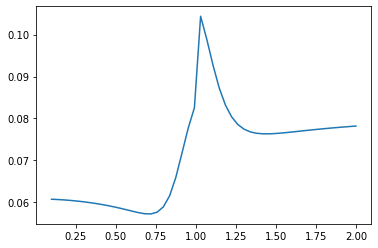

In [6]:
qob_lis=[q.Qobj(rho_effective[el],dims=[[2,2],[2,2]]) for el in lambdarange]
rho_2lis=[rho_2_finite(i) for i in range(len(lambdarange))]
diff_lis=[None]*len(lambdarange)
for j in range(len(lambdarange)):
    diff_lis[j]=rho_2lis[j]-qob_lis[j]
eig_diff_lis=[x.eigenenergies() for x in diff_lis]
sum_eig_diff=[sum(np.abs(vec)) for vec in eig_diff_lis ]

plt.plot(lambdarange,sum_eig_diff)

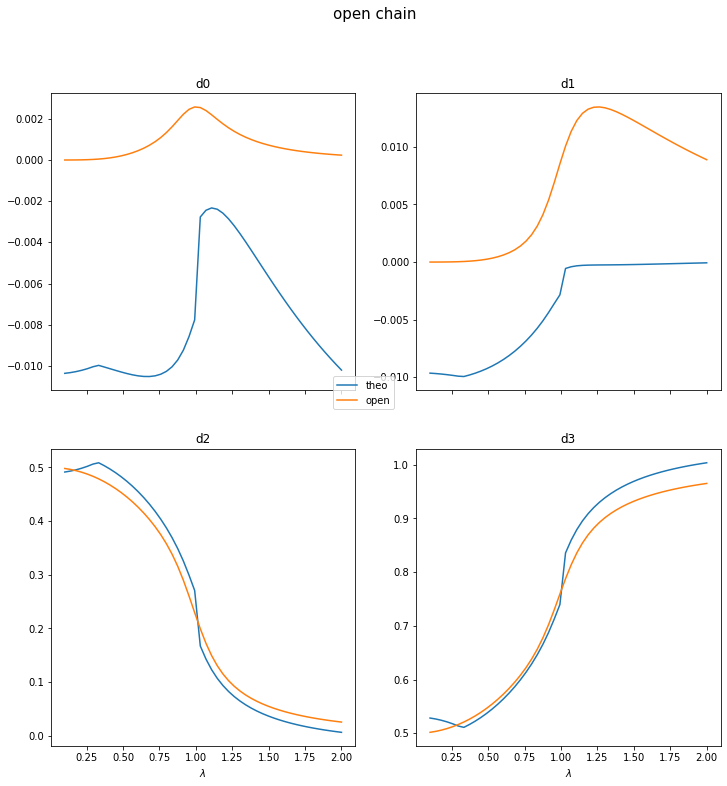

In [12]:
fig, axs = plt.subplots(2, 2,sharex=True,figsize=[12,12])

for k in range(4):
    kb=format(k,"02b")
    kbvec=[int(x) for x in str(kb)]
    specvec= np.zeros_like(lambdarange)
    i=0
    for el in lambdarange:
        specvec[i]=rho_spectra[el][k]
        i+=1
    
    theovec=np.zeros_like(lambdarange)
    for el in np.arange(len(lambdarange)):
        theovec[el]=rho_2_finite(el).eigenenergies()[k]

    axs[kbvec[0], kbvec[1]].plot(lambdarange,theovec,label="theo")
    axs[kbvec[0], kbvec[1]].plot(lambdarange,specvec,label="open")
    axs[kbvec[0], kbvec[1]].set_title('d'+str(k))
handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center')
fig.suptitle(r"open chain",fontsize=15)
axs[1,1].set_xlabel(r"$\lambda$")
axs[1,0].set_xlabel(r"$\lambda$")
plt.show()    